<a href="https://colab.research.google.com/github/whataLIN/DeepLearning/blob/main/whataLIN/ch09_DL_09_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN으로 원하는 이미지 생성

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼 패러미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else 'cpu')
print(f'사용하고 있는 디바이스 : {DEVICE}')

사용하고 있는 디바이스 : cuda


In [3]:
# 데이터셋 로딩
# Fashoin MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8180127.43it/s] 


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144783.41it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2754132.22it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20841966.21it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(110, 256), # tensor 100개 input -> 110개 -> 100개 + 10개의 라벨을 합쳐줘서 학습
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024), # 한 층 더 늚 (이전 예제에 비해)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

        self.embed = nn.Embedding(10, 10) # n x 1 -> n x 10 연속적으로 곱하기
        # 연속된 임베딩을 층을 만들어줘야 학습에 유리
    
    def forward(self, z, labels): # 가짜 이미지가 될 확률분포 텐서 z
        c = self.embed(labels) # 정답값 층을 임베딩한(연속적으로 확장시킨) c
        x = torch.cat([z, c], 1) # 라벨과 z를 이어붙임 (무작위 벡터, 클래스 레이블)
        return self.model(x)

![cGAN 생성자](https://github.com/BigData23th/Data/raw/main/dl_05_04.png)
> cGAN 생성자


In [5]:
# 판별자도 레이블 정보를 입력 받음
# -> 생성자에서 이미지를 만들 때 쓴 레이블 정보를 입력 받아서
# "레이블이 주어졌을 때 가짜인 확률과 진짜인 확률"을 추정
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(28 * 28 + 10, 1024), # 794, 1024. 임베딩시켜 입력받음
            # 레이블 정보를 전달하기 위해 이미지 크기 (28*28 = 784)에 10을 더해줌
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # 성능 개선용 드롭아웃
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # 성능 개선용 드롭아웃
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # 성능 개선용 드롭아웃
            nn.Linear(256, 1), # 진짜인지 가짜인지 1로 (이진분류)
            nn.Sigmoid() # 0~1.
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x) # 진짜인지 가짜인지 (0, 1)

![cGAN 판별자](https://github.com/BigData23th/Data/raw/main/dl_05_05.png)
> cGAN 판별자

In [6]:
# 모델 인스턴스 생성
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 오차함수 & 최적화함수
criterion = nn.BCELoss() # 이진 크로스 엔트로피 (Binary Cross Entropy) 오차함수
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    # i: 100개인데, 배치 사이즈가 10이면? [0, 1, 2, 3... 9]
    # (data, label) -> 이미지, 이미지의 분류
    # ---
    # for i, (images, _) in enumerate(train_loader): # DataLoader는 BatchSize만큼 끊어서 데이터를 제공
    for i, (images, labels) in enumerate(train_loader): # cGAN에서는 라벨이 중요
        # BATCH_SIZE, 1, 28, 28 -> BATCH_SIZE, 784
        # 임베딩이 원핫인코딩의 형태태
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE) # 진짜 이미지

        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # 1로 채워진 텐서
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # 0로 채워진 텐서

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        labels = labels.to(DEVICE)
        outputs = D(images, labels) # 판별자가 진짜 이미지 + 라벨값을 0~1으로 진짜/가짜 여부를 판단
        d_loss_real = criterion(outputs, real_labels) # BCELoss
        real_score = outputs # 판별자 vs 진짜 이미지

        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE) # 정규분포를 따르는 100개의 특성을 가진 가짜 이미지 텐서
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE) # 가짜 이미지의 가짜 답(랜덤으로 만들어진)
        # 정규분포로부터 생성된 무작위 텐서를 (생성자 모델이) 입력받아서 실제 이미지와 차원(모양)이 같은 텐서를 생성
        fake_images = G(z, g_label)

        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images, g_label)
        # 판별자가 맞추었는가?
        d_loss_fake = criterion(outputs, fake_labels) # 오차
        fake_score = outputs # 판별자 vs 가짜 이미지

        # 진짜와 가짜 이미지를 가지고 낸 오차
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step() # 판별자의 패러미터 개선

        # 생성자가 판별자를 속였는지에 대해 (생성자 성능) 오차를 계산
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        # 생성자가 속였는가?
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step() # 생성자의 패러미터 개선
    # ---
    # 학습 진행도 체크 로그
    # 판별자가 진짜를 알아본 정확도 D(x)와 가짜를 진짜로 인식한 정확도 D(G(z))
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/300], d_loss: 1.1388, g_loss: 4.7316, D(x): 0.78, D(G(z)): 0.32
Epoch [1/300], d_loss: 0.6895, g_loss: 2.8284, D(x): 0.74, D(G(z)): 0.12
Epoch [2/300], d_loss: 0.3491, g_loss: 4.1222, D(x): 0.94, D(G(z)): 0.13
Epoch [3/300], d_loss: 0.2011, g_loss: 4.6527, D(x): 0.93, D(G(z)): 0.07
Epoch [4/300], d_loss: 0.3846, g_loss: 3.1265, D(x): 0.89, D(G(z)): 0.13


KeyboardInterrupt: ignored

In [8]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [ ]:
!wget https://github.com/BigData23th/Data/raw/main/d2.pt
!wget https://github.com/BigData23th/Data/raw/main/g2.pt

In [10]:
D.load_state_dict(torch.load('d2.pt'))
G.load_state_dict(torch.load('g2.pt'))

<All keys matched successfully>

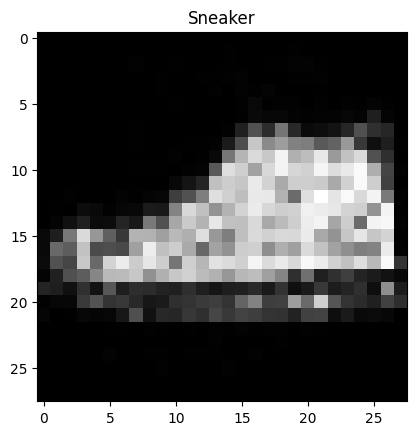

In [20]:
# 만들고 싶은 아이템 생성하고 시각화하기
# 아이템 번호
item_number = 7 #@param {"type":"number"}
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label) # 텐서
# CPU, Numpy -> Matplotlib
sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28)) # 784
plt.title(CLASSES[item_number])
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()